In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader

from torchvision.datasets import ImageFolder
 
import torch
from torchvision import transforms, datasets
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

In [3]:
transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet input
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [4]:
path = r"F:\Dataset\FoodSeg103_img\IR"

data_train = datasets.ImageFolder(path, transform=transforms)
 
data_loader = DataLoader(data_train, batch_size=64, shuffle=True)

In [5]:
data_train = datasets.ImageFolder(path, transform=transforms)

# split ds init
train_ratio = 0.8  # 80% for train，20% for test
train_size = int(len(data_train) * train_ratio)
test_size = len(data_train) - train_size

# split
train_dataset, test_dataset = random_split(data_train, [train_size, test_size])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
print(f"Total images: {len(data_train)}")
print(f"Training images: {len(train_dataset)}")
print(f"Testing images: {len(test_dataset)}")

Total images: 18313
Training images: 14650
Testing images: 3663


In [7]:
print(len(data_train))  # number of all image

18313


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7865399].


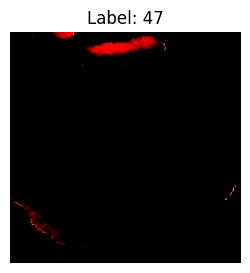

In [8]:
import matplotlib.pyplot as plt
import random

# random seclect
random_idx = random.randint(0, len(train_dataset) - 1)  # random index
image, label = train_dataset[random_idx]  # get image and label

# visible
plt.figure(figsize=(3, 3))
plt.imshow(image.permute(1, 2, 0))  # HWC
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()


In [9]:
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 103)
model = model.to(device)

F:\Anaconda\envs\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
F:\Anaconda\envs\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [11]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        print(f"\nStarting Epoch {epoch + 1}/{num_epochs}...")
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # f
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # b and op
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # cal acc
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # look process
            if (batch_idx + 1) % 500 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{batch_idx + 1}/{len(train_loader)}], "
                      f"Loss: {loss.item():.4f}, Accuracy: {100 * correct / total:.2f}%")
        
        # look each epoch
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        print(f"Epoch {epoch + 1} completed with Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

In [12]:
train_model(model, train_loader, criterion, optimizer, num_epochs=30)


Starting Epoch 1/30...
Epoch 1 completed with Loss: 2.2010, Accuracy: 46.71%

Starting Epoch 2/30...
Epoch 2 completed with Loss: 1.4239, Accuracy: 60.97%

Starting Epoch 3/30...
Epoch 3 completed with Loss: 1.1620, Accuracy: 67.00%

Starting Epoch 4/30...
Epoch 4 completed with Loss: 0.9751, Accuracy: 71.65%

Starting Epoch 5/30...
Epoch 5 completed with Loss: 0.8098, Accuracy: 75.75%

Starting Epoch 6/30...
Epoch 6 completed with Loss: 0.6772, Accuracy: 79.67%

Starting Epoch 7/30...
Epoch 7 completed with Loss: 0.5590, Accuracy: 83.09%

Starting Epoch 8/30...
Epoch 8 completed with Loss: 0.4662, Accuracy: 85.89%

Starting Epoch 9/30...
Epoch 9 completed with Loss: 0.3798, Accuracy: 88.68%

Starting Epoch 10/30...
Epoch 10 completed with Loss: 0.2991, Accuracy: 91.17%

Starting Epoch 11/30...
Epoch 11 completed with Loss: 0.2607, Accuracy: 92.17%

Starting Epoch 12/30...
Epoch 12 completed with Loss: 0.2319, Accuracy: 93.32%

Starting Epoch 13/30...
Epoch 13 completed with Loss: 0.1

In [13]:
evaluate_model(model, test_loader)

# save
torch.save(model.state_dict(), "resnet50_foodseg103_50ep.pth")

Test Accuracy: 60.33%
